# Paper Plots
This notebook is used to collect some of the code used to produce the plots particularly for the analysis note.

In [1]:
import os, sys, glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import hist
from hist import Hist
import pickle
import mplhep as hep
import math
from tabulate import tabulate
import itertools
import warnings
import scipy
from plot_utils import *
import fill_utils

warnings.filterwarnings('ignore')
hep.style.use("CMS")
matplotlib.rcParams.update({'figure.max_open_warning': 0})
matplotlib.rcParams['figure.facecolor'] = 'white'

## Notebook Parameters
The following couple cells define the input and output directories, and load in the desired .pkl files into the `plots` nested dictionary.<br>
`output_label`: _str_, saves plots as `<output_label>+<plot_name>.<file_ext>`.<br>
`file_ext`: _str_, see above.<br>

In [3]:
# parameters
output_label = '/home/submit/lavezzo/public_html/SUEP/analysis/paper_plots_v2/'
AN_label = '/home/submit/lavezzo/SUEP/AN-22-133/images/offline/{}.pdf'
file_ext = '.pdf'

The `plots` dictionary is used to store all the plots imported from the pickle files. Dimensions: (sample) x (plot label) <br>
The `loader` function in `plot_utils.py` automatically merges all the QCD HT and QCD pT bins into one sample ('QCD_HT' and 'QCD_Pt'), applies the lumis, and excludes some of the low QCD bins.<br>

In [ ]:
# create output dir
if not os.path.isdir(output_label): 
    print("Creating", output_label)
    os.mkdir(output_label)

# This part is meant to be flxeible, depending on what you want to import
# dimensions: (sample) x (plot label)

# input .pkl files
plotDir = '/work/submit/{}/SUEP/outputs/'.format(os.environ['USER'])
infile_names = glob.glob(plotDir+'*.pkl')

# generate list of files that you want to merge histograms for
offline_files_SUEP = [f for f in infile_names if "sys_studies_v5.pkl" in f and ('SUEP-m' in f)]
offline_files_2018 = [f for f in infile_names if "sys_studies_v5.pkl" in f and ('20UL18' in f or 'Run2018' in f)]
offline_files_2017 = [f for f in infile_names if "sys_studies_v5.pkl" in f and ('20UL17' in f or 'Run2017' in f)]
offline_files_2016 = [f for f in infile_names if "sys_studies_v5.pkl" in f and ('20UL16' in f or 'Run2016' in f)]

# merge the histograms, apply lumis, exclude low HT bins
plots_SUEP_2018 = loader(offline_files_SUEP, year=2018, exclude_low_bins=True)
plots_SUEP_2017 = loader(offline_files_SUEP, year=2017, exclude_low_bins=True)
plots_SUEP_2016 = loader(offline_files_SUEP, year=2016, exclude_low_bins=True)
plots_2018 = loader(offline_files_2018, auto_lumi=True, exclude_low_bins=True)
plots_2017 = loader(offline_files_2017, auto_lumi=True, exclude_low_bins=True)
plots_2016 = loader(offline_files_2016, auto_lumi=True, exclude_low_bins=True)

# put everything in one dictionary
plots = {}
for key in plots_SUEP_2018.keys(): plots[key+"_2018"] = fill_utils.apply_normalization(plots_SUEP_2018[key], fill_utils.getXSection(key + '+RunIIAutumn18-private+MINIAODSIM', '2018', SUEP=True))
for key in plots_SUEP_2017.keys(): plots[key+"_2017"] = fill_utils.apply_normalization(plots_SUEP_2017[key], fill_utils.getXSection(key + '+RunIIAutumn18-private+MINIAODSIM', '2018', SUEP=True))
for key in plots_SUEP_2016.keys(): plots[key+"_2016"] = fill_utils.apply_normalization(plots_SUEP_2016[key], fill_utils.getXSection(key + '+RunIIAutumn18-private+MINIAODSIM', '2018', SUEP=True))
for key in plots_2018.keys(): plots[key+"_2018"] = plots_2018[key]
for key in plots_2017.keys(): plots[key+"_2017"] = plots_2017[key]
for key in plots_2016.keys(): plots[key+"_2016"] = plots_2016[key]

These are all the samples loaded.

In [ ]:
keys = list(plots.keys())
keys.sort()
for k in keys: print(k)

hep.style.use("CMS")

In [41]:
plots.keys()
import uproot
with uproot.recreate("predicted_data_2017.root") as froot:
    for h, hist in plots['data_2017'].items():
        froot[h] = hist

## 1D Comparison

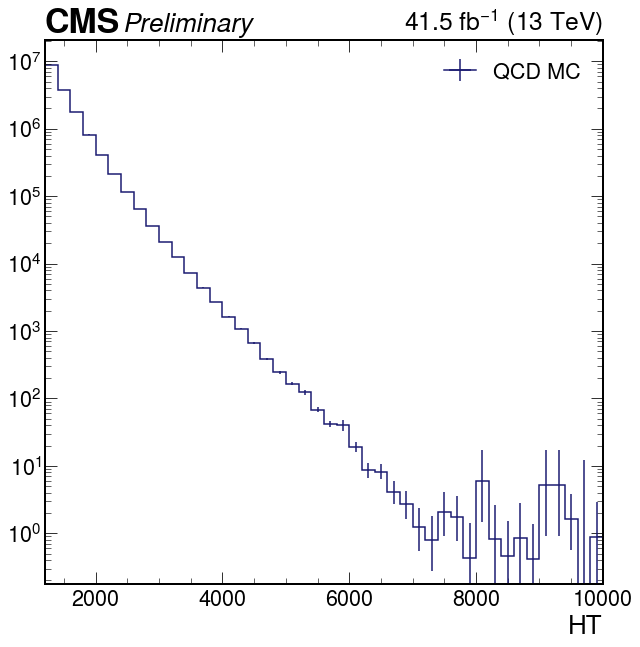

In [36]:
plot_label = 'ht_Cluster'
year = '2017'

samples = ['QCD_HT_'+year]
labels = ['QCD MC', r'$M_{S}=125$ GeV',r'$M_{S}=400$ GeV',r'$M_{S}=750$ GeV',r'$M_{S}=1000$ GeV']
density = False

fig, ax = plt.subplots(figsize=(10, 10))
hep.cms.label(llabel='Preliminary',data=False, lumi=lumiLabel(year))

for label, sample in zip(labels, samples): 
    
    h = plots[sample][plot_label][::2j]
    
    if density: h = h/h.sum().value
            
    hep.histplot(h, yerr=True, label=label, color=default_colors[sample]) 

# tweak these by hand, as needed
#plt.ylim(1e0,2e6)
plt.xlim(1200,10000)
plt.legend(loc='best')
plt.yscale("log")

# save and show
plt.savefig(AN_label.format("HT_"+year))
#plt.savefig(output_label+plot_label+"_"+year+file_ext)
plt.show()

## Extended ABCD

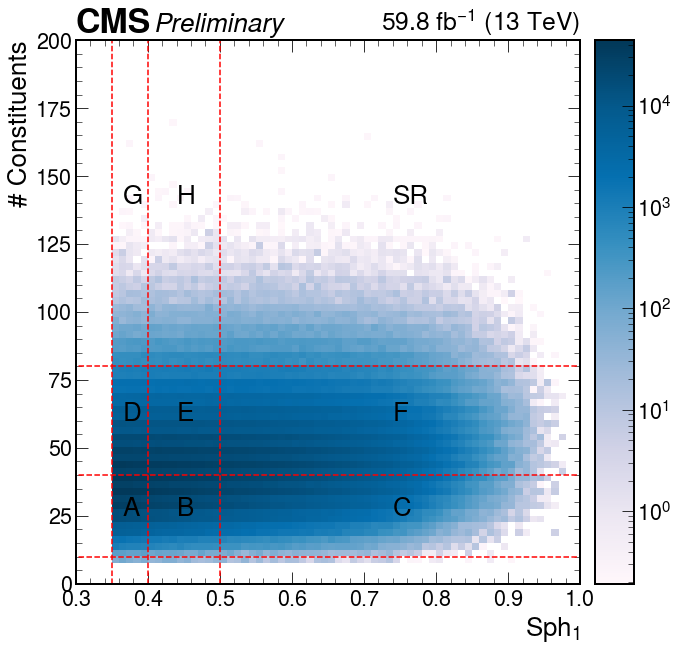

In [17]:
plot_label = '2D_SUEP_S1_vs_SUEP_nconst_Cluster'
sample = 'QCD_HT_2018'
#samples += ['SUEP-m125-generic', 'SUEP-m400-generic', 'SUEP-m750-generic', 'SUEP-m1000-generic']
draw_lines = True
lines_x = [0.35,0.4, 0.5, 1.0]
lines_y = [10,40,80, 200]

fig, ax = plt.subplots(figsize=(10, 10))

k = 0
regions = ['A','B','C','D','E','F','G','H','SR']
for i in range(len(lines_y)-1):
    for j in range(len(lines_x)-1):
        xloc = (lines_x[j+1] + lines_x[j])/2 - 0.01
        yloc = (lines_y[i+1] + lines_y[i])/2
        plt.text(xloc, yloc, regions[k])
        k+=1
    
if plots[sample][plot_label].sum().value == 0:
    print("Histogram empty for sample", sample)

h = plots[sample][plot_label]
bins = np.linspace(0,500,10)
h = h[0.35j:,10j::1j]

hep.cms.label(llabel='Preliminary',data=False, lumi=lumiLabel(year))
_ = hep.hist2dplot(h, 
           norm=matplotlib.colors.LogNorm(),
           cmap = 'PuBu',
           cbar=True,
           label=sample) 

# draw lines to visualize ABCD regions
if draw_lines:
    for y in lines_y: plt.plot([0,10000], [y,y], color='red', linestyle='dashed')
    for x in lines_x: plt.plot([x,x], [0,1000], color='red', linestyle='dashed')

# cms = fig.text(
#     55, 10., u"CMS $\it{preliminary}$",
#     fontsize=20, fontweight='bold',
# )
# lumi = fig.text(
#     164, 10., r"%.1f fb$^{-1}$ (13 TeV)" % 35.9,
#     fontsize=18, 
# )

plt.ylim(0,200)
plt.xlim(0.3,1.0)
plt.savefig(AN_label.format("extendedABCD_regions_2018"))
plt.savefig(output_label+""+file_ext)
plt.show()

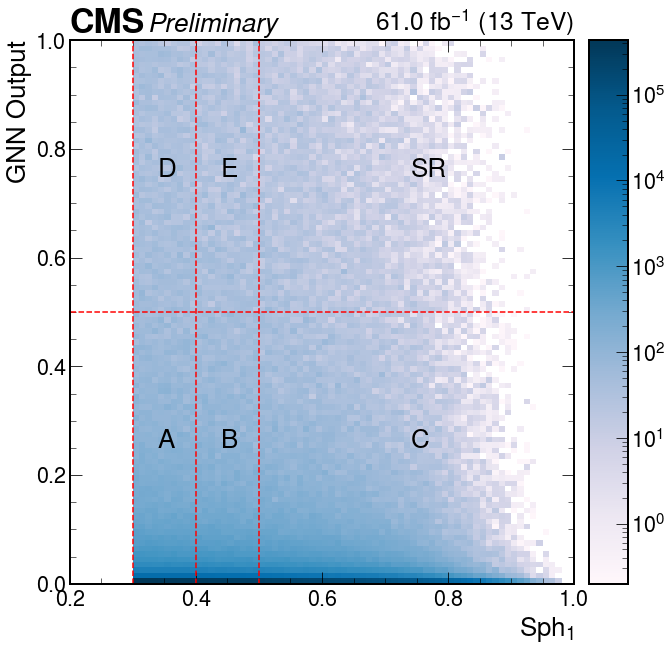

In [48]:
plot_label = '2D_SUEP_S1_vs_single_l5_bPfcand_S1_SUEPtracks_GNN'
sample = 'QCD_HT_2018'
#samples += ['SUEP-m125-generic', 'SUEP-m400-generic', 'SUEP-m750-generic', 'SUEP-m1000-generic']
draw_lines = True
lines_x = [0.3,0.4, 0.5, 1.0]
lines_y = [0,0.5,1]

fig, ax = plt.subplots(figsize=(10, 10))

k = 0
regions = ['A','B','C','D','E','SR']
for i in range(len(lines_y)-1):
    for j in range(len(lines_x)-1):
        xloc = (lines_x[j+1] + lines_x[j])/2 - 0.01
        yloc = (lines_y[i+1] + lines_y[i])/2
        plt.text(xloc, yloc, regions[k])
        k+=1
    
if plots[sample][plot_label].sum().value == 0:
    print("Histogram empty for sample", sample)

h = plots[sample][plot_label]
h = h[0.3j:,:]

hep.cms.label(llabel='Preliminary',data=False, lumi=61.0)
_ = hep.hist2dplot(h, 
           norm=matplotlib.colors.LogNorm(),
           cmap = 'PuBu',
           cbar=True,
           label=sample) 

# draw lines to visualize ABCD regions
if draw_lines:
    for y in lines_y: plt.plot([0,10000], [y,y], color='red', linestyle='dashed')
    for x in lines_x: plt.plot([x,x], [0,1000], color='red', linestyle='dashed')

# cms = fig.text(
#     55, 10., u"CMS $\it{preliminary}$",
#     fontsize=20, fontweight='bold',
# )
# lumi = fig.text(
#     164, 10., r"%.1f fb$^{-1}$ (13 TeV)" % 35.9,
#     fontsize=18, 
# )

plt.ylim(0,1)
plt.xlim(0.2,1.0)
plt.savefig(AN_label.format("ML_extendedABCD_regions_2018"))
plt.savefig(output_label+""+file_ext)
plt.show()

## ABCD - QCD Background

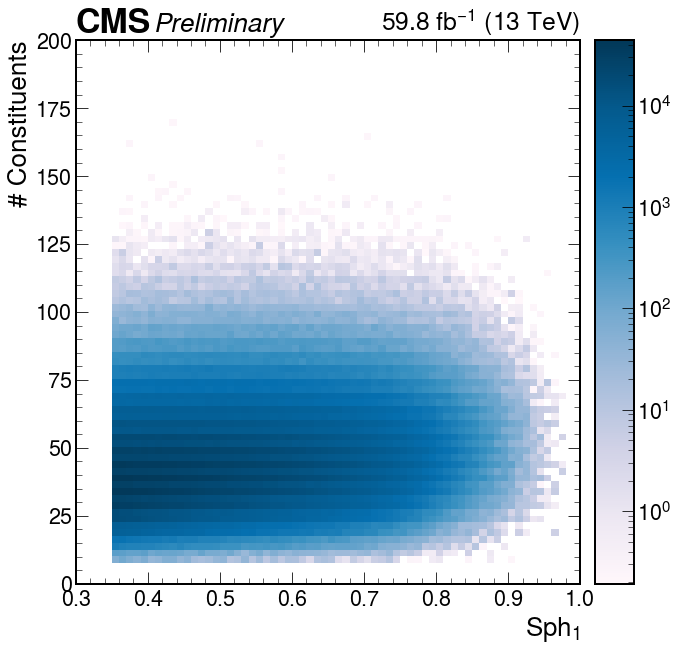

In [18]:
plot_label = '2D_SUEP_S1_vs_SUEP_nconst_Cluster'
year = '2018'
sample = 'QCD_HT_'+year

fig, ax = plt.subplots(figsize=(10, 10))
    
if plots[sample][plot_label].sum().value == 0:
    print("Histogram empty for sample", sample)

h = plots[sample][plot_label]
h = h[0.35j:,10j:]

hep.cms.label(llabel='Preliminary',data=False, lumi=lumiLabel(year))
_ = hep.hist2dplot(h, 
           norm=matplotlib.colors.LogNorm(),
           cmap = 'PuBu',
           cbar=True,
           label=sample) 

plt.ylim(0,200)
plt.xlim(0.3,1.0)
plt.savefig(AN_label.format("2D_decorrelate_"+year))
plt.savefig(output_label+"2D_decorrelate_"+year+file_ext)
plt.show()

## ABCD - MC Closure

In [ ]:
plot_label = '2D_SUEP_S1_vs_SUEP_nconst_Cluster'
year = '2018'

abcd = plots['QCD_HT_'+year][plot_label]

# 2D_SUEP_S1_vs_SUEP_nconst_Cluster
# 2D_ISR_S1_vs_ISR_nconst_ClusterInverted
xregions = [0.35j, 0.4j, 0.5j, 1.0j]
yregions = [10j, 40j, 80j, 300j]

# 2D_SUEP_S1_vs_SUEP_nconst_Cluster
# 2D_ISR_S1_vs_ISR_nconst_ClusterInverted
# xregions = [0.35j, 0.4j, 0.5j, 1.0j]
# yregions = [20j, 40j, 60j, 300j]

# 2D_ISR_S1_ISR_nconst_CL
# xregions = [0.35j, 0.4j, 0.5j, 1.0j]
# yregions = [0.0j, 30j, 60j, 300j]

# 2D_SUEP_S1_SUEP_nconst_CL (scouting)
# xregions = [0.35j, 0.4j, 0.5j, 1.0j]
# yregions = [10.0j, 35j, 60j, 300j]

#SR, SR_exp = ABCD_4regions(abcd, [0.35j,0.5j,1.0j], [10j,80j,300j], sum_var='x')
SR, SR_exp, alpha, sigma_alpha = ABCD_9regions_errorProp(abcd, xregions, yregions, sum_var='x')

edges = SR.axes[0].edges
new_bins = np.concatenate((np.linspace(80,120,10), [125,130,135,140,180]))
SR = rebin_piecewise(SR, new_bins)
SR_exp = rebin_piecewise(SR_exp, new_bins)

print("Scaling factor alpha:", alpha)
print("Sigma alpha:", sigma_alpha)

# pull test
diffs = np.abs(SR_exp.values() - SR.values())
tot_sigma = np.sqrt(SR.variances()**2 + SR_exp.variances()**2)
pull_ratios = np.where(tot_sigma > 0, diffs/tot_sigma, 0) + 1

# chi2 test
tot_sigma = np.sqrt(SR.variances()**2 + SR_exp.variances()**2)
chi2 = np.sum(np.where(tot_sigma > 0, (SR.values() - SR_exp.values())**2 / tot_sigma**2, 0)) / len(tot_sigma[tot_sigma > 0])
print(chi2)

# use the custom plot_ratio
# the hist implementation used elsewhere in the notebook doesn't use the 
# errors in the hists' bins to calculate the errors in the ratio plot
fig, axs = plot_ratio([SR_exp, SR], labels=["$SR_{obs}$", "$SR_{exp}$"])
_ = axs[0].scatter([], [], marker='+', s=100, label='Pull')
_ = axs[1].scatter(SR.axes[0].centers, pull_ratios, marker='+', s=100, label='Pull')
_ = axs[0].plot([],[],' ',label=r'$\chi^2$: {}'.format(round(chi2,3)))
_ = axs[1].set_ylim(0,3)
_ = axs[0].legend(prop={"family":"DejaVu Sans"})
_ = axs[1].set_yticks(ticks=[0,1,2], labels=['-1','0','1'])
_ = axs[1].set_ylabel("1 - Ratio")
cms = axs[0].text(
        58, 70000., u"CMS $\it{Preliminary}$",
        fontsize=24, fontweight='bold',
    )
lumi = axs[0].text(
        150, 70000., r"%.1f fb$^{-1}$ (13 TeV)" % round(lumiLabel(year),1),
        fontsize=22, 
    )
plt.savefig(AN_label.format("closure_"+year))
plt.savefig(output_label+"closure_"+year+file_ext)

Scaling factor alpha: 2.26818218881235
Sigma alpha: 0.0385054555960370


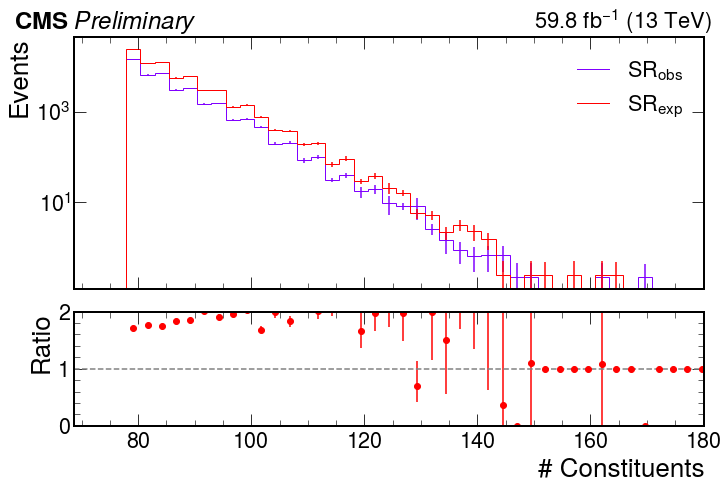

In [10]:
plot_label = '2D_SUEP_S1_vs_SUEP_nconst_Cluster'
year = '2018'

abcd = plots['QCD_HT_'+year][plot_label]

# 2D_SUEP_S1_vs_SUEP_nconst_Cluster
# 2D_ISR_S1_vs_ISR_nconst_ClusterInverted
xregions = [0.35j, 0.5j, 1.0j]
yregions = [10j, 80j, 300j]

# 2D_SUEP_S1_vs_SUEP_nconst_Cluster
# 2D_ISR_S1_vs_ISR_nconst_ClusterInverted
# xregions = [0.35j, 0.4j, 0.5j, 1.0j]
# yregions = [20j, 40j, 60j, 300j]

# 2D_ISR_S1_ISR_nconst_CL
# xregions = [0.35j, 0.4j, 0.5j, 1.0j]
# yregions = [0.0j, 30j, 60j, 300j]

# 2D_SUEP_S1_SUEP_nconst_CL (scouting)
# xregions = [0.35j, 0.4j, 0.5j, 1.0j]
# yregions = [10.0j, 35j, 60j, 300j]

SR, SR_exp = ABCD_4regions(abcd, xregions, yregions, sum_var='x')

print("Scaling factor alpha:", alpha)
print("Sigma alpha:", sigma_alpha)

# use the custom plot_ratio
# the hist implementation used elsewhere in the notebook doesn't use the 
# errors in the hists' bins to calculate the errors in the ratio plot
fig, axs = plot_ratio([SR_exp, SR], labels=["$SR_{obs}$", "$SR_{exp}$"])
_ = axs[1].set_ylim(0,2)
_ = axs[0].legend()
cms = axs[0].text(
        58, 70000., u"CMS $\it{Preliminary}$",
        fontsize=24, fontweight='bold',
    )
lumi = axs[0].text(
        150, 70000., r"%.1f fb$^{-1}$ (13 TeV)" % round(lumiLabel(year),1),
        fontsize=22, 
    )
# plt.savefig(AN_label.format("closure_"+year))
# plt.savefig(output_label+"closure_"+year+file_ext)

## ABCD - MC ML Closure

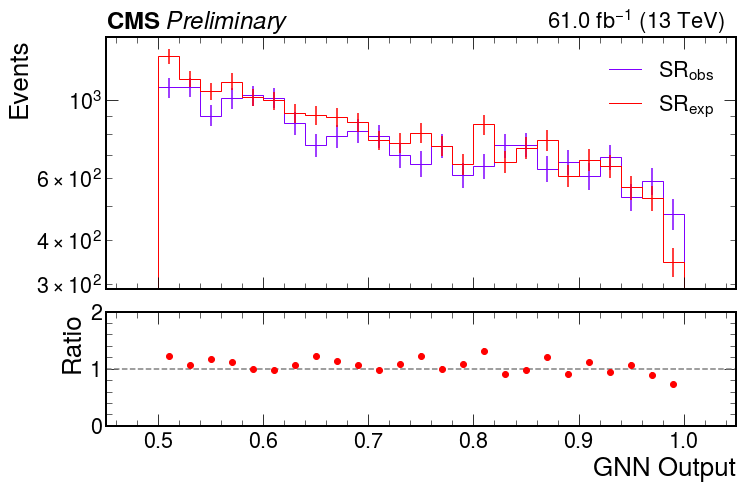

In [43]:
plot_label = '2D_SUEP_S1_vs_single_l5_bPfcand_S1_SUEPtracks_GNN'
year = '2018'
abcd = plots['QCD_HT_'+year][plot_label]

xregions = [0.3j, 0.4j, 0.5j, 1.0j]
yregions = [0.0j, 0.5j, 1.0j]

SR, SR_exp = ABCD_6regions(abcd, xregions, yregions, sum_var='x')

SR = SR[::2j]
SR_exp = SR_exp[::2j]

fig, axs = plot_ratio([SR_exp, SR], labels=["$SR_{obs}$", "$SR_{exp}$"])
_ = axs[1].set_ylim(0,2)
_ = axs[0].legend()
cms = axs[0].text(
    0.45, 1600., u"CMS $\it{Preliminary}$",
    fontsize=24, fontweight='bold',
)
lumi = axs[0].text(
    0.87, 1600., r"%.1f fb$^{-1}$ (13 TeV)" % round(lumiLabel(year),1),
    fontsize=22, 
)
plt.savefig(AN_label.format("ML_closure_"+year))
plt.savefig(output_label+"ML_closure_"+year+file_ext)

## ABCD - Final

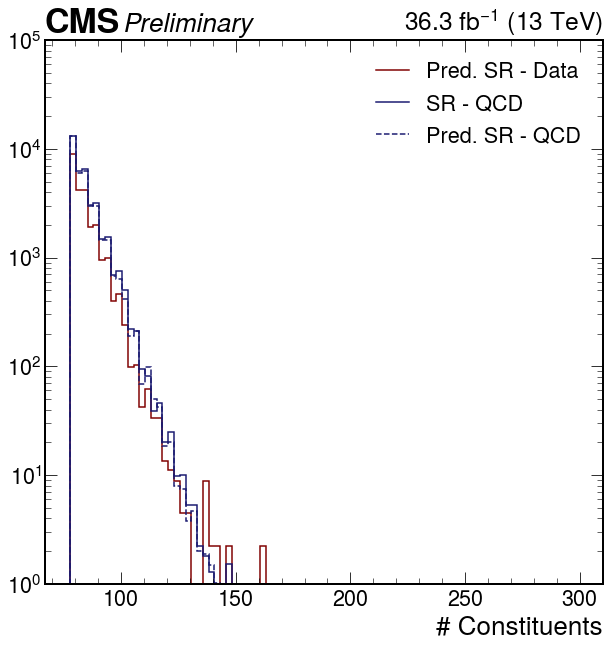

In [29]:
plot_label = '2D_SUEP_S1_vs_SUEP_nconst_Cluster'
year = '2016'
abcd = plots['QCD_HT_'+year][plot_label]

xregions = [0.35j, 0.4j, 0.5j, 1.0j]
yregions = [10j, 40j, 80j, 300j]
SR, SR_exp, alpha, sigma_alpha = ABCD_9regions_errorProp(abcd, xregions, yregions, sum_var='x')
_, SR_exp_data, _, _ = ABCD_9regions_errorProp(plots['data_'+year][plot_label], xregions, yregions, sum_var='x')

# use the custom plot_ratio
# the hist implementation used elsewhere in the notebook doesn't use the 
# errors in the hists' bins to calculate the errors in the ratio plot
# fig, axs, _ = plot_ratio(SR_exp, SR, 
#                          "# Constituents in SUEP", "$SR_{obs}$ - QCD", "$SR_{exp}$ - Data")
# _ = axs[1].set_ylim(0,3.0)
# _ = axs[0].legend()

fig, ax = plt.subplots(figsize=(10, 10))
hep.cms.label(llabel='Preliminary',data=False, lumi=lumiLabel(year))
hep.histplot(SR_exp_data, yerr=False, label="Pred. SR - Data", color=default_colors['data'])    
hep.histplot(SR, yerr=False, label="SR - QCD", color=default_colors['QCD'])    
hep.histplot(SR_exp, yerr=False, label="Pred. SR - QCD", color=default_colors['QCD'], linestyle='dashed')    

samples = ['SUEP-m125-generic-htcut_'+year, 'SUEP-m400-generic_'+year,
          'SUEP-m750-generic_'+year, 'SUEP-m1000-generic_'+year]
labels = [r'$M_{S}=125$ GeV',r'$M_{S}=400$ GeV',r'$M_{S}=750$ GeV',r'$M_{S}=1000$ GeV']
for sample, label in zip(samples, labels):
    abcd = plots[sample][plot_label]
    SUEP_SR = abcd[0.5j:1.0j:sum,80j:300j]
    #hep.histplot(SUEP_SR, yerr=False, label=label, color=default_colors[sample])    

plt.legend()
plt.yscale("log")
plt.ylim(1e0,1e5)
plt.savefig(AN_label.format("final_"+year))
plt.savefig(output_label+"final_"+year+file_ext)

36247.44231942287 385.7573954407017
105 10
2040 45
397 20
163 13


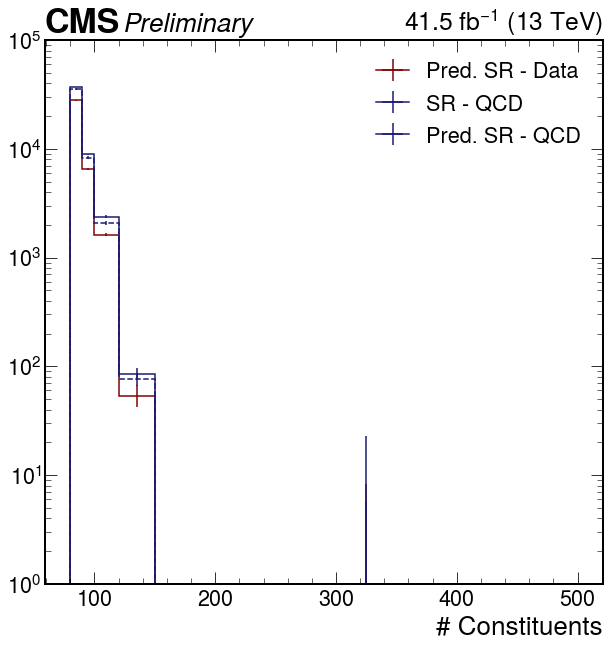

In [41]:
plot_label = '2D_SUEP_S1_vs_SUEP_nconst_Cluster'
year = '2017'
abcd = plots['QCD_HT_'+year][plot_label]

newbins = [80, 90, 100, 120, 150, 500]
xregions = [0.35j, 0.4j, 0.5j, 1.0j]
yregions = [10j, 40j, 80j, 300j]
SR, SR_exp, alpha, sigma_alpha = ABCD_9regions_errorProp(abcd, xregions, yregions, sum_var='x')
_, SR_exp_data, _, _ = ABCD_9regions_errorProp(plots['data_'+year][plot_label], xregions, yregions, sum_var='x')

print(SR_exp_data.sum().value, np.sqrt(SR_exp_data.sum().variance))

# use the custom plot_ratio
# the hist implementation used elsewhere in the notebook doesn't use the 
# errors in the hists' bins to calculate the errors in the ratio plot
# fig, axs, _ = plot_ratio(SR_exp, SR, 
#                          "# Constituents in SUEP", "$SR_{obs}$ - QCD", "$SR_{exp}$ - Data")
# _ = axs[1].set_ylim(0,3.0)
# _ = axs[0].legend()

fig, ax = plt.subplots(figsize=(10, 10))
hep.cms.label(llabel='Preliminary',data=False, lumi=lumiLabel(year))
hep.histplot(rebin_piecewise(SR_exp_data, newbins), yerr=True, label="Pred. SR - Data", color=default_colors['data'])    
hep.histplot(rebin_piecewise(SR, newbins), yerr=True, label="SR - QCD", color=default_colors['QCD'])    
hep.histplot(rebin_piecewise(SR_exp, newbins), yerr=True, label="Pred. SR - QCD", color=default_colors['QCD'], linestyle='dashed')    

samples = ['SUEP-m125-generic-htcut_'+year, 'SUEP-m400-generic_'+year,
          'SUEP-m750-generic_'+year, 'SUEP-m1000-generic_'+year]
labels = [r'$M_{S}=125$ GeV',r'$M_{S}=400$ GeV',r'$M_{S}=750$ GeV',r'$M_{S}=1000$ GeV']
for sample, label in zip(samples, labels):
    abcd = plots[sample][plot_label]
    SUEP_SR = abcd[0.5j:1.0j:sum,80j:300j]
    print(round(SUEP_SR.sum().value), round(np.sqrt(SUEP_SR.sum().value)))
    #hep.histplot(rebin_piecewise(SUEP_SR, newbins), yerr=False, label=label, color=default_colors[sample])    

plt.legend()
plt.yscale("log")
plt.ylim(1e0,1e5)
plt.savefig(AN_label.format("final_bin_"+year))
plt.savefig(output_label+"final_bin_"+year+file_ext)

## ML ABCD - Final

(1.0, 100000.0)

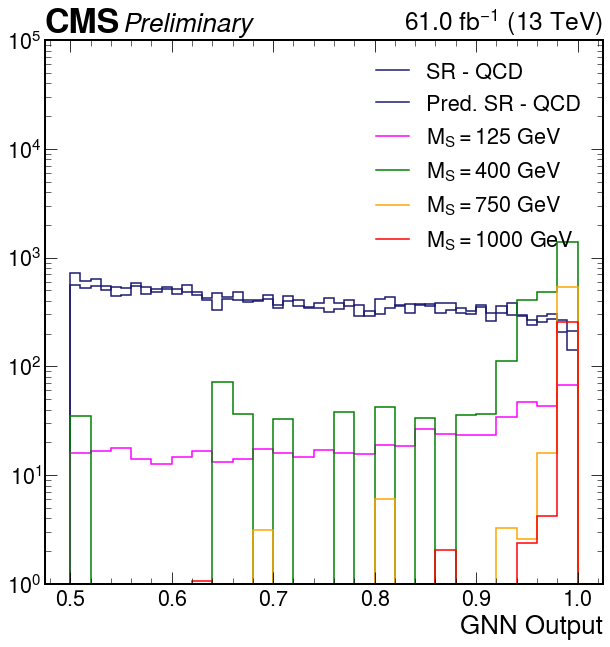

In [ ]:
plot_label = '2D_SUEP_S1_vs_single_l5_bPfcand_S1_SUEPtracks_GNN'
year = '2018'
abcd = plots['QCD_HT_'+year][plot_label]

xregions = [0.3j, 0.4j, 0.5j, 1.0j]
yregions = [0.0j, 0.5j, 1.0j]

SR, SR_exp = ABCD_6regions(abcd, xregions, yregions, sum_var='x')
_, SR_exp_data = ABCD_6regions(plots['data_'+year][plot_label], xregions, yregions, sum_var='x')

# use the custom plot_ratio
# the hist implementation used elsewhere in the notebook doesn't use the 
# errors in the hists' bins to calculate the errors in the ratio plot
# fig, axs, _ = plot_ratio(SR_exp, SR, 
#                          "# Constituents in SUEP", "$SR_{obs}$ - QCD", "$SR_{exp}$ - Data")
# _ = axs[1].set_ylim(0,3.0)
# _ = axs[0].legend()

fig, ax = plt.subplots(figsize=(10, 10))
hep.cms.label(llabel='Preliminary',data=False, lumi=lumiLabel(year))
hep.histplot(SR_exp_data, yerr=False, label="Pred. SR - Data", color=default_colors['data'])    
hep.histplot(SR, yerr=False, label="SR - QCD", color=default_colors['QCD'])    
hep.histplot(SR_exp, yerr=False, label="Pred. SR - QCD", color=default_colors['QCD'])    

samples = ['SUEP-m125-generic-htcut', 'SUEP-m400-generic',
          'SUEP-m750-generic', 'SUEP-m1000-generic']
labels = [r'$M_{S}=125$ GeV',r'$M_{S}=400$ GeV',r'$M_{S}=750$ GeV',r'$M_{S}=1000$ GeV']
for sample, label in zip(samples, labels):
    abcd = plots[sample][plot_label]
    SUEP_SR = abcd[0.5j:1.0j:sum,0.5j:1.0j:2j]
    hep.histplot(SUEP_SR, yerr=False, label=label, color=default_colors[sample])    

plt.legend(loc='best')
plt.yscale("log")
plt.ylim(1e0,1e5)
plt.savefig(AN_label.format("ML_final_"+year))
plt.savefig(output_label+"ML_final_"+year+file_ext)

## ABCD - 1D Correlation

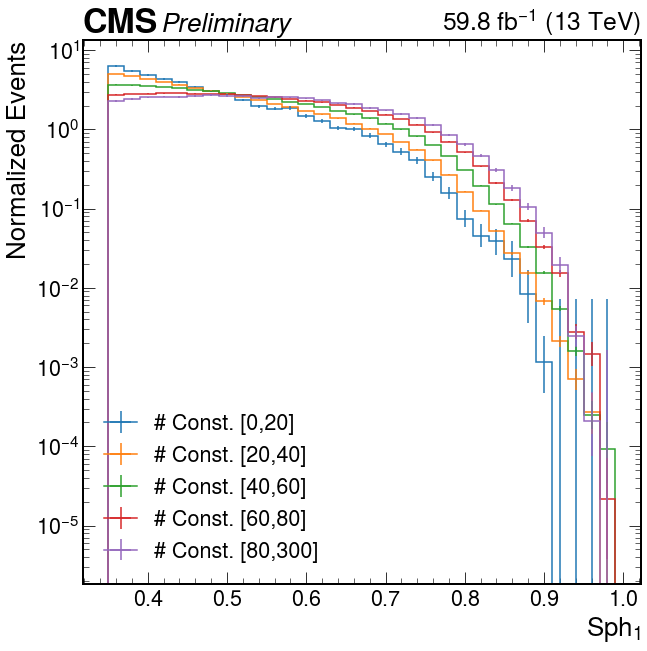

In [15]:
# parameters
plot_label = '2D_SUEP_S1_vs_SUEP_nconst_Cluster'
year = '2018'
sample = 'QCD_HT_'+year

fig, ax = plt.subplots(figsize=(10, 10))
hep.cms.label(llabel='Preliminary',data=False, lumi=round(lumiLabel(year),1))

slices = [[0j,20j],[20j,40j],[40j,60j],[60j,80j],[80j,300j]]
for j in range(len(slices)):
    val_lo = slices[j][0]
    val_up = slices[j][1]

    h = plots[sample][plot_label][0.35j::2j,val_lo:val_up:sum]

    hep.histplot(h,
                 yerr=True, density=True, 
                 label="# Const. [{0},{1}]".format(round(val_lo.imag), round(val_up.imag)))    

plt.legend()
#plt.ylim(1e-6,1e0)
plt.yscale('log')
plt.ylabel("Normalized Events")
plt.xlabel(r"$Sph_{1}$")
plt.savefig(AN_label.format("1D_decorrelate_" + year))
plt.savefig(output_label + "1D_decorrelate_" + year + file_ext,  bbox_inches='tight')
plt.show()

## ABCD - data/MC Control Regions

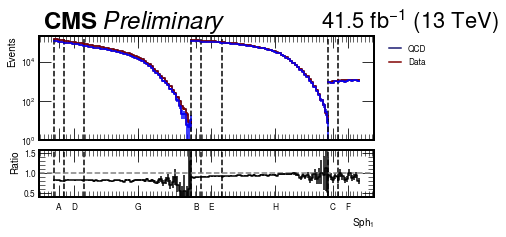

In [43]:
x = 'ABCDEFGH'
y = 'ADGBEHCF'
year = '2017'
plot_labels = ['SUEP_S1_Cluster']
for plot_label in plot_labels:
    fig, (ax1, ax2) = plot_ratio_regions(plots, 'A_'+plot_label, 
                           'data_'+year, 'QCD_HT_'+year,
                           y, density=False)
    ax1.legend(labels=['QCD','Data'], loc='upper left', bbox_to_anchor=(1.02, 1))
    cms = ax1.text(
        -0.05, 5e5, u"CMS $\it{Preliminary}$",
        fontsize=24, fontweight='bold',
    )
    lumi = ax1.text(
        1.15, 5e5, r"%.1f fb$^{-1}$ (13 TeV)" % round(lumiLabel(year),1),
        fontsize=22, 
    )
    ax1.set_ylim(1e0, 2e5)
    #plt.savefig(AN_label.format("control_regions_ratio_" + year))
    fig.savefig(output_label + 'control_regions_ratio_' + year + file_ext, bbox_inches='tight')

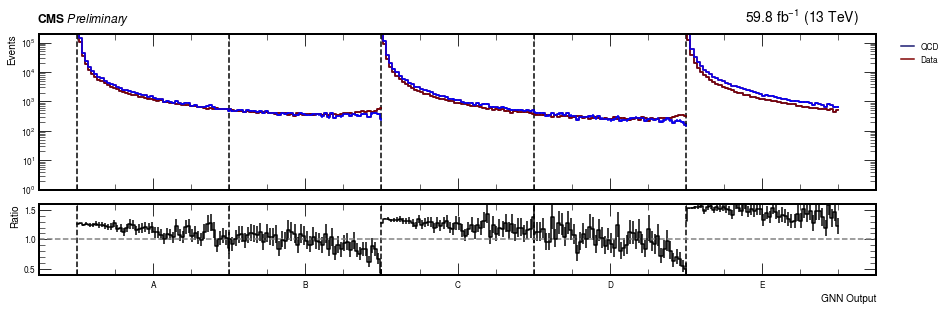

In [56]:
x = 'ABCDE'
y = 'ABCDE'
year = '2018'
plot_labels = ['single_l5_bPfcand_S1_SUEPtracks_GNN']
for plot_label in plot_labels:
    fig, (ax1, ax2) = plot_ratio_regions(plots, 'A_'+plot_label, 
                           'data_'+year, 'QCD_HT_'+year,
                           y, density=False)
    ax1.legend(labels=['QCD','Data'], loc='upper left', bbox_to_anchor=(1.02, 1))
    cms = ax1.text(
        -0.13, 5e5, u"CMS $\it{Preliminary}$",
        fontsize=12, fontweight='bold',
    )
    lumi = ax1.text(
        2.15, 5e5, r"%.1f fb$^{-1}$ (13 TeV)" % round(lumiLabel(year),1),
        fontsize=14, 
    )
    ax1.set_ylim(1e0, 2e5)
    fig.set_size_inches(15, 6)
    plt.savefig(AN_label.format("ML_control_regions_ratio_" + year))
    fig.savefig(output_label + 'ML_control_regions_ratio_' + year + file_ext, bbox_inches='tight')

## ABCD - Contamination Control Regions

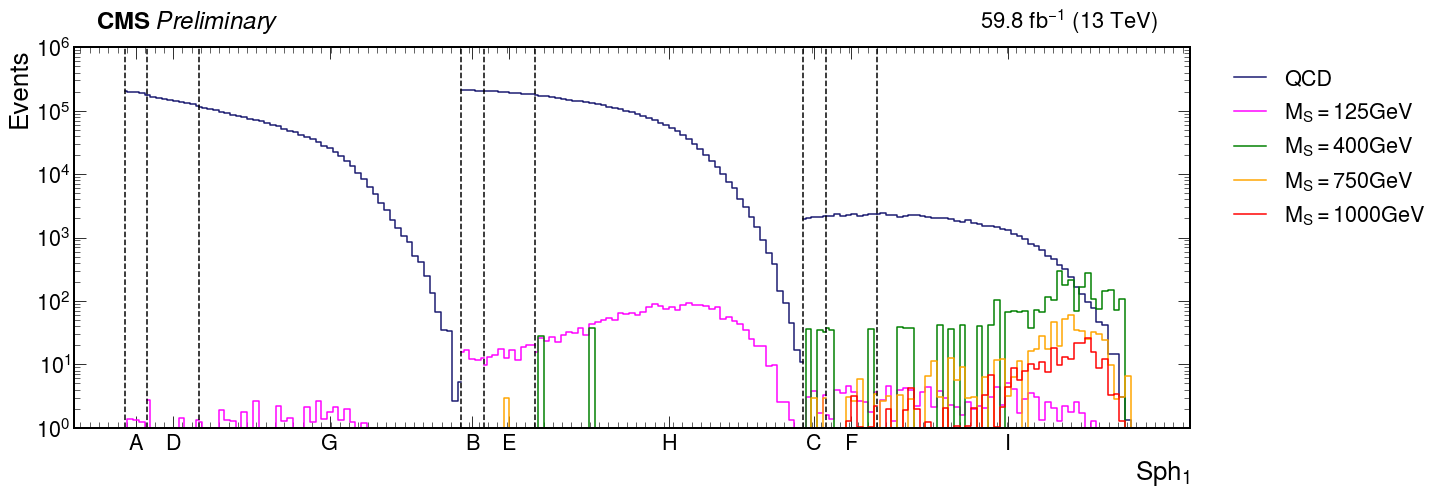

In [39]:
x = 'ABCDEFGHI'
y = 'ADGBEHCFI'

year = '2018'
plot_labels = ['SUEP_S1_Cluster']
samples = ['QCD_HT_'+year, 'SUEP-m125-generic-htcut_'+year, 'SUEP-m400-generic_'+year,
         'SUEP-m750-generic_'+year, 'SUEP-m1000-generic_'+year]
#samples = ['QCD_HT_'+year]
labels = ['QCD', r'$M_{S} = 125 GeV$', r'$M_{S} = 400 GeV$',
          r'$M_{S} = 750 GeV$', r'$M_{S} = 1000 GeV$']
for plot_label in plot_labels:
    fig, ax = plot_all_regions(plots, 'A_'+plot_label, samples, 
                               labels=labels, regions=y, density=False)
    #ax.legend(labels=['QCD','Data'], loc='upper left', bbox_to_anchor=(1.02, 1))
    cms = ax.text(
        -0.05, 2000000., u"CMS $\it{Preliminary}$",
        fontsize=24, fontweight='bold',
    )

    lumi = ax.text(
        1.5, 2000000., r"%.1f fb$^{-1}$ (13 TeV)" % round(lumiLabel(year),1),
        fontsize=22, 
    )
    ax.set_ylim(1e0, 1e6)
    ax.set_xlabel(r"$Sph_1$")
    fig.savefig(AN_label.format('contamination_'+year), bbox_inches='tight')
    fig.savefig(output_label + 'contamination_' + year + file_ext, bbox_inches='tight')

## Contamination Table

In [14]:
plot_label = 'SUEP_S1_Cluster'

samples = ['SUEP-m125-generic-htcut', 'SUEP-m400-generic',
          'SUEP-m750-generic', 'SUEP-m1000-generic']
labels = ['$m_{S} = 125 \GeV$', '$m_{S} = 400 \GeV$',
          '$m_{S} = 750 \GeV$', '$m_{S} = 1000 \GeV$']
regions = 'ABCDE'

for year in ['2018']:
    QCD_sample = 'QCD_HT_'+year
    for label, sample in zip(labels, samples):
        line = label + ' & '
        for i, region in enumerate(regions):
            h = plots[sample][region + "_" + plot_label]
            total = h.sum().value
            line += '$' + str(round(total)) + '\\pm' + str(round(np.sqrt(total))) + '$'

            if i == len(regions)-1: line += ' \\\\'
            else: line += ' & '
        print(line)
    print()

$m_{S} = 125 \GeV$ & $1270\pm36$ & $17591\pm133$ & $3222\pm57$ & $1866\pm43$ & $39349\pm198$ \\
$m_{S} = 400 \GeV$ & $0\pm0$ & $0\pm0$ & $103\pm10$ & $0\pm0$ & $0\pm0$ \\
$m_{S} = 750 \GeV$ & $0\pm0$ & $0\pm0$ & $6\pm2$ & $0\pm0$ & $3\pm2$ \\
$m_{S} = 1000 \GeV$ & $0\pm0$ & $0\pm0$ & $0\pm0$ & $0\pm0$ & $0\pm0$ \\



In [16]:
regions = 'ABCDEFGH'

for year in ['2018']:
    QCD_sample = 'QCD_HT_'+year
    for label, sample in zip(labels, samples):
        line = label + ' & '
        for i, region in enumerate(regions):
            h = plots[sample][region + "_" + plot_label]
            hQCD = plots[QCD_sample][region + "_" + plot_label]
            alpha = h.sum().value
            beta = hQCD.sum().value
            total = alpha/beta * 100
            err = np.sqrt(alpha * (beta**-2) + (alpha**2) * (beta**-3)) * 100
            line += '$' + str(round(total,2)) + '\\pm' + str(round(err,2)) + '$'

            if i == len(regions)-1: line += ' \\\\'
            else: line += ' & '
        print(line)
    print()

$m_{S} = 125 \GeV$ & $0.13\pm0.0$ & $1.69\pm0.01$ & $31.08\pm0.63$ & $0.13\pm0.0$ & $2.04\pm0.01$ & $33.41\pm0.44$ & $0.66\pm0.01$ & $17.73\pm0.03$ \\
$m_{S} = 400 \GeV$ & $0.0\pm0.0$ & $0.0\pm0.0$ & $1.0\pm0.1$ & $0.0\pm0.0$ & $0.0\pm0.0$ & $0.48\pm0.05$ & $0.0\pm0.0$ & $0.0\pm0.0$ \\
$m_{S} = 750 \GeV$ & $0.0\pm0.0$ & $0.0\pm0.0$ & $0.06\pm0.02$ & $0.0\pm0.0$ & $0.0\pm0.0$ & $0.07\pm0.02$ & $0.0\pm0.0$ & $0.0\pm0.0$ \\
$m_{S} = 1000 \GeV$ & $0.0\pm0.0$ & $0.0\pm0.0$ & $0.0\pm0.0$ & $0.0\pm0.0$ & $0.0\pm0.0$ & $0.04\pm0.01$ & $0.0\pm0.0$ & $0.0\pm0.0$ \\



In [24]:
#ML

regions = 'ABCDE'

for year in ['2018']:
    QCD_sample = 'QCD_HT_'+year
    for label, sample in zip(labels, samples):
        line = label + ' & '
        for i, region in enumerate(regions):
            h = plots[sample][region + "_" + plot_label]
            hQCD = plots[QCD_sample][region + "_" + plot_label]
            alpha = h.sum().value
            beta = hQCD.sum().value
            total = alpha/beta * 100
            err = np.sqrt(alpha * (beta**-2) + (alpha**2) * (beta**-3)) * 100
            line += '$' + str(round(total,2)) + '\\pm' + str(round(err,2)) + '$'

            if i == len(regions)-1: line += ' \\\\'
            else: line += ' & '
        print(line)
    print()

QCD & $100.0\pm0.07$ & $100.0\pm1.01$ & $100.0\pm0.08$ & $100.0\pm1.18$ & $100.0\pm0.06$ \\
$M_{S} = 125 GeV$ & $0.0\pm0.0$ & $0.14\pm0.03$ & $0.0\pm0.0$ & $0.25\pm0.04$ & $0.04\pm0.0$ \\
$M_{S} = 400 GeV$ & $0.0\pm0.0$ & $0.35\pm0.04$ & $0.0\pm0.0$ & $0.5\pm0.06$ & $0.0\pm0.0$ \\
$M_{S} = 750 GeV$ & $0.0\pm0.0$ & $0.03\pm0.01$ & $0.0\pm0.0$ & $0.09\pm0.02$ & $0.0\pm0.0$ \\
$M_{S} = 1000 GeV$ & $0.0\pm0.0$ & $0.01\pm0.01$ & $0.0\pm0.0$ & $0.05\pm0.02$ & $0.0\pm0.0$ \\



## ML Systematic

In [6]:
# parameters
plot_label = '2D_ISR_S1_vs_single_l5_bPfcand_S1_SUEPtracks_GNNInverted'
sample1 = 'QCD_HT_2018'
sample2 = 'data_2018'

h1 = plots[sample1][plot_label]
h2 = plots[sample2][plot_label]

h1 = h1[0.0j::sum, 0.0j::5j]
h2 = h2[0.0j::sum, 0.0j::5j]

fig = plt.figure(figsize=(10, 8))
      
fig, axs, _ = plot_ratio(h1, h2, label1=r'QCD - $H_T$ Binned', label2 = 'Data')
axs[0].legend()
axs[1].set_ylim(0.5,2.5)
#axs[0].set_yscale("linear")
cms = axs[0].text(
    -0.25, 4.5e7, u"CMS $\it{Preliminary}$",
    fontsize=24, fontweight='bold',
)
lumi = axs[0].text(
    0.78, 4.5e7, r"%.1f fb$^{-1}$ (13 TeV)" % round(lumis[year]/1000,1),
    fontsize=22, 
)
plt.savefig(AN_label.format("ML_systematic_"+year))

TypeError: plot_ratio() got an unexpected keyword argument 'label1'

<Figure size 720x576 with 0 Axes>